✅ Degradation updated in Bearing1_1_features_with_labels.csv
✅ Degradation updated in Bearing1_2_features_with_labels.csv
✅ Degradation updated in Bearing1_3_features_with_labels.csv
✅ Degradation updated in Bearing1_4_features_with_labels.csv
✅ Degradation updated in Bearing1_5_features_with_labels.csv
✅ Degradation updated in Bearing2_1_features_with_labels.csv
✅ Degradation updated in Bearing2_2_features_with_labels.csv
✅ Degradation updated in Bearing2_3_features_with_labels.csv
✅ Degradation updated in Bearing2_4_features_with_labels.csv
✅ Degradation updated in Bearing2_5_features_with_labels.csv
✅ Degradation updated in Bearing3_1_features_with_labels.csv
✅ Degradation updated in Bearing3_2_features_with_labels.csv
✅ Degradation updated in Bearing3_3_features_with_labels.csv
✅ Degradation updated in Bearing3_4_features_with_labels.csv
✅ Degradation updated in Bearing3_5_features_with_labels.csv


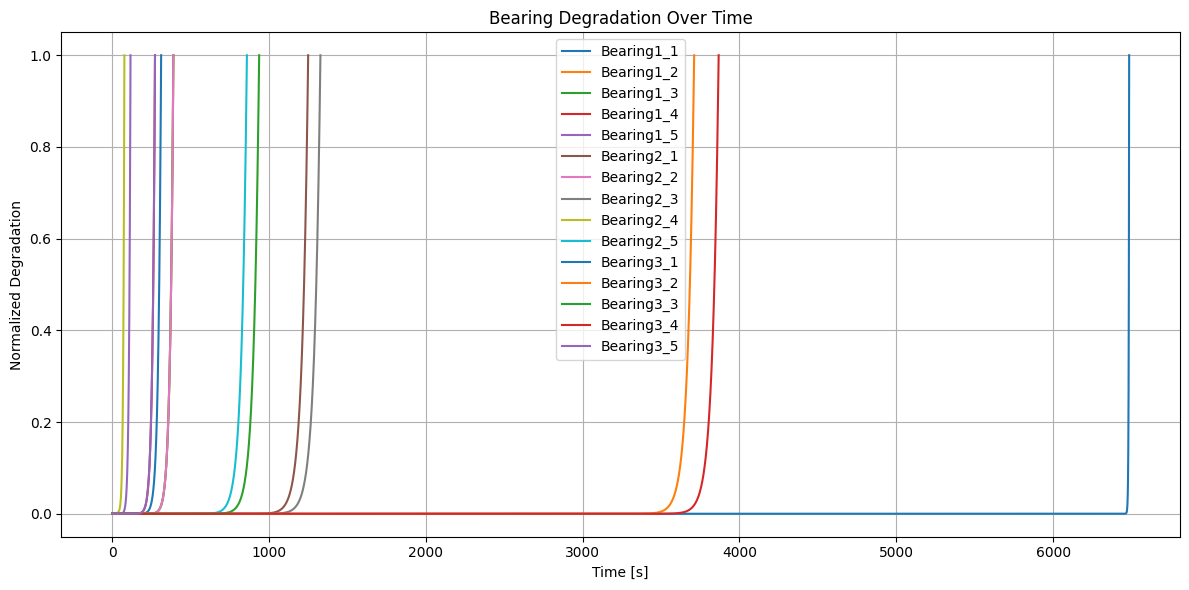

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

input_folder = 'tf_features_xjtu'

bearings = {
    '100Hz4kN': {
        'bearings': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'],
        'RPM': 2100.0,
        'Load': 12000.0
    },
    '100Hz4.2kN': {
        'bearings': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5'],
        'RPM': 2250.0,
        'Load': 11000.0
    },
    '100Hz5kN': {
        'bearings': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5'],
        'RPM': 2400.0,
        'Load': 10000.0
    }
}

# Constants
C = 12000.0
p = 3.0                # fatigue exponent
beta = 1e-6            # coupling fatigue to EDV growth
phi = 1e-5             # EDV growth coefficient
q = 4.0                # EDV load exponent
Dm = 0.025             # ball diameter [m]

# Lubricant & thermal
k_B = 8.617e-5         # Boltzmann constant [eV/K]
alpha = 1e-5           # viscosity degradation coefficient
nu0 = 1e-5             # baseline lubricant viscosity
E_vis = 0.1            # viscosity activation energy (eV)
T0 = 293.15              # reference temperature [K]
k_o = 1e-4             # oxidation rate coefficient
O_max = 1.0            # max oxidation level

# Wear parameters
A_v = 1e-5            # Archard wear coefficient
H_hard = 1.5e9         # hardness of material
A_a = 1e-6             # roughness-induced wear coefficient
gamma_r = 1e-3         # roughness evolution from wear
delta_c = 1e-5         # roughness evolution from debris
rho = 1e6              # debris generation from wear

# Geometric correction
eta = 1e6              # saturation coefficient for volume
zeta = 1e12            # saturation coefficient for roughness

# Thermal & friction
gamma_w = 0.5           # weight of wear in degradation
zeta_L = 0.5            # weight of thermal effects
m_cp = 3.77e6           # mass * specific heat
mu_f = 0.005            # friction coefficient
h_A = 5.0               # heat transfer coefficient
T_a = 293.15            # ambient temperature
xi = 100.0              # exothermic contribution from oxidation
E_a = 0.1               # oxidation activation energy (eV)


def derivatives(y, t, params, T):
    """
    Compute the derivatives of the degradation model using NumPy.

    Args:
        y: array of shape (6,) -> [V_d, V, R, O, C_debris, D]
        Load: float
        RPM: float
        T: float (temperature)

    Returns:
        array of shape (6,) with derivatives
    """
    V_d, V, R, O, C_debris, D = y
    T = float(T(t))

    # Angular velocity
    omega = 2.0 * np.pi * RPM / 60.0

    # Oxidation dynamics
    dO_dt = (
        params['k_o']
        * (params['O_max'] - O)
        * np.exp(-params['E_a'] / (k_B * T))
    )

    # Thermal dynamics
    dT_dt = (1.0 / params['m_cp']) * (
        params['mu_f'] * Load * omega
        - params['h_A'] * (T - params['T_a'])
        + params['xi'] * dO_dt
    )

    # Viscosity
    nu = params['nu0'] * np.exp(
        -params['alpha'] * O
        - params['E_vis'] / (k_B * T)
        + params['E_vis'] / (k_B * params['T0'])
    )

    # Sliding speed
    ds_dt = np.pi * params['Dm'] * (RPM / 60.0)

    # Geometric and debris corrections
    W_mod = 1.0 / (1.0 + params['eta'] * V + params['zeta'] * R**2)
    C_eff = (
        params['C_load']
        * (nu / params['nu0'])
        * W_mod
        * np.exp(-params['psi'] * C_debris)
    )

    # Fatigue and wear
    dVd_dt = params['phi'] * (Load / C_eff)**params['q'] * RPM
    dV_dt = ((params['A_v'] * Load / params['H_hard']) * ds_dt) + (params['A_a'] * R)
    dR_dt = params['gamma_r'] * dV_dt + params['delta_c'] * C_debris
    dCdebris_dt = params['rho'] * dV_dt

    kf = (Load / C_eff)**params['p'] * RPM / (60.0 * 1e6)

    # Total degradation
    dD_dt = (
        kf
        + params['beta'] * dVd_dt
        + params['gamma_w'] * dV_dt
        + params['zeta_L'] * dT_dt
    )

    return np.array([dVd_dt, dV_dt, dR_dt, dO_dt, dCdebris_dt, dD_dt])


# Prepare plot
plt.figure(figsize=(12, 6))

for condition, info in bearings.items():
    RPM = info['RPM']
    Load = info['Load']
    
    for bearing in info['bearings']:
        filename = f'{bearing}_features_with_labels.csv'
        file_path = os.path.join(input_folder, filename)

        if not os.path.exists(file_path):
            print(f"⚠️ File not found: {filename}")
            continue

        df = pd.read_csv(file_path)

        # if 'Time' not in df.columns or 'Temperature' not in df.columns:
        #     print(f"⚠️ Missing 'Time' or 'Temperature' in {filename}")
        #     continue

        df['RPM'] = RPM
        df['Load'] = Load

        t_measured = df['Time'].to_numpy()

        T_measured = np.ones_like(t_measured) * 293.15

        T_interp = interp1d(t_measured, T_measured, fill_value='extrapolate')

        params = {
            'P': Load,
            'n': RPM,
            'C_load': C,
            'p': 3.0,
            'q': 4.0,
            'phi': 1e-5,
            'beta': beta,
            'A_v': A_v,
            'H_hard': H_hard,
            'A_a': A_a,
            'gamma_r': gamma_r,
            'delta_c': delta_c,
            'eta': eta,
            'zeta': zeta,
            'k_o': k_o,
            'O_max': O_max,
            'E_a': E_a,
            'nu0': nu0,
            'E_vis': E_vis,
            'T0': T0,
            'psi': 1e-6,
            'rho': rho,
            'gamma_w': gamma_w,
            'alpha': alpha,
            'zeta_L': zeta_L,
            'm_cp': m_cp,
            'mu_f': mu_f,
            'h_A': h_A,
            'T_a': T_a,
            'xi': xi,
            'Dm': Dm,
            'k_B': k_B,
            
        }

        y0 = [0.0, 0.0, 1e-6, 0.0, 0.0, 0.0]
        sol = odeint(derivatives, y0, t_measured, args=(params, T_interp))
        D = sol[:, -1]
        normalized_degradation = (D - D.min()) / (D.max() - D.min())
        df['Degradation'] = normalized_degradation
        df.to_csv(file_path, index=False)
        print(f"✅ Degradation updated in {filename}")

        # Plot degradation
        plt.plot(t_measured, normalized_degradation, label=bearing)

plt.xlabel('Time [s]')
plt.ylabel('Normalized Degradation')
plt.title('Bearing Degradation Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()